# MF 815
group member: Xizhi Wang, Yuqing Liu, Che Wang, Haozhi Cheng


Enviroment

In [ ]:
from sklearn.model_selection import train_test_split
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
from math import ceil
import string
import nltk
import collections
import random
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xizhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xizhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Q1 :Split the data into training and testing.

#### Reference: Hao Xing(2022) NLP_app/NLP_Deep_Learning_Questrom_WS_03_2020.ipynb [Source code]. https://questromtools.bu.edu/portal/site/SPRG22MF815D1E1/tool

In [ ]:

def get_data(PATH):
    """function to process the data and get fund_names and texts from the summaries.

    Args:
        PATH (str): the path to summary

    Returns:
        fund_names (list): list of fund names
        text (list): list of summaries.
    

    """
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    
    for i in tqdm (range (1), desc="Reading data..."): # progress bar
        for ii, filename in enumerate(list_dir) :
            with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
                txt = f.read()
                try :
                    txt_split = txt.split('<head_breaker>')
                    summary = txt_split[1].strip()
                    fund_name = txt_split[0].strip()
                except :
                    summary = txt
                    fund_name = ''
            texts.append(summary)
            fund_names.append(fund_name)
    return fund_names, texts

In [ ]:
fund_names, summaries = get_data('MutualFundSummary')

Reading data...: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


In [ ]:
df_extraction = pd.DataFrame({'fund_name': fund_names, 'summaries': summaries})
m_fund_l_df = pd.read_csv('MutualFundLabels.csv')
# y = np.array([m_fund_l_df[m_fund_l_df['fund_name'] == f]['Ivestment Strategy'] \
    # for f in fund_names])


In [ ]:
len(m_fund_l_df[m_fund_l_df['Ivestment Strategy']=='Commodities Fund (Low Risk)'])

1

In [ ]:
m_fund_l_df.drop(m_fund_l_df[m_fund_l_df['Ivestment Strategy']=='Commodities Fund (Low Risk)'].index, inplace = True)

In [ ]:
len(m_fund_l_df[m_fund_l_df['Ivestment Strategy']=='Commodities Fund (Low Risk)'])

0

In [ ]:
df_extraction.head()

,fund_name,summaries
0,AB All Market Income Portfolio,AB ALL MARKET INCOME PORTFOLIO\n--------------...
1,AB All Market Real Return Portfolio,AB ALL MARKET REAL RETURN PORTFOLIO\n---------...
2,AB Arizona Portfolio,AB Arizona Portfolio\n------------------------...
3,AB Asia ex-Japan Equity Portfolio,AB ASIA EX-JAPAN EQUITY PORTFOLIO\n-----------...
4,AB Balanced Wealth Strategy Portfolio,AB VPS BALANCED WEALTH STRATEGY PORTFOLIO\n---...


In [ ]:
# Split the data into training and testing.
total_strategy_df = m_fund_l_df[['fund_name', 'Ivestment Strategy']].merge(df_extraction, on = 'fund_name', how = 'left').dropna()
tt_df = train_test_split(total_strategy_df, test_size = 0.3, random_state = 777)
train_df = tt_df[0]
test_df =tt_df[1]

**make sure there is Long Short Funds(High Risk in both strategy_df)**

In [ ]:
np.unique(train_df['Ivestment Strategy'])


array(['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)',
       'Fixed Income Long Only (Low Risk)',
       'Long Short Funds (High Risk)'], dtype=object)

In [ ]:
np.unique(test_df['Ivestment Strategy'])

array(['Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)',
       'Fixed Income Long Only (Low Risk)',
       'Long Short Funds (High Risk)'], dtype=object)

In [ ]:
'''
#TF-idf
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)
'''


'\n#TF-idf\ndef lemma_tokenizer(text):\n    lemmatizer=WordNetLemmatizer()\n    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("\'"," "))]\nstop_words = set(stopwords.words("english")+list(string.punctuation)+[\'``\',"\'\'"]+["]","[","*"]+[\'doe\', \'ha\', \'wa\'])\ntfidf = TfidfVectorizer(input=\'content\', tokenizer=lemma_tokenizer, stop_words=stop_words)\ntfidf_train = tfidf.fit_transform(X_train)\ntfidf_test = tfidf.transform(X_test)\n'

# Q2:Following the NLP application in class, use the skip-gram model to build a word embedding dictionary from the mutual fund summaries in the training set.

#### reference: Hao Xing(2022) NLP_app/NLP_Deep_Learning_Questrom_WS_03_2020.ipynb [Source code]. https://questromtools.bu.edu/portal/site/SPRG22MF815D1E1/too

In [ ]:
# stop words set
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

def tokenizer(txt):
    """tokenizer

    Args:
        txt (str): text to be tokenized

    Returns:
        filtered_sentence (list): list of tokenized string.  
    """
    txt = txt.lower().replace('\t', ' ').replace('\n', ' ')
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence
    
train_text_words = np.concatenate([tokenizer(s) for s in train_df['summaries']])
    


In [ ]:
# training parameters for skip-gram model
batch_size = 120
num_epochs = 2
# word2vec parameters
embedding_size = 50 # size of embedding vector
max_vocabulary_size = 5000 #  number of different words in vocabulary
min_occurrence = 10 # words must appear at least 10 times
skip_window = 3 # how many words to consider left and right
num_skips = 4 # how many times to reuse an input to generate a label


In [ ]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Count the most common words
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break


In [ ]:
# give a unique id to each words in the vocabulary
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

unk_count = 0 # we still need to count the unkown words(the words that are not in the word2id)
data = [] # turn words in train_text_words into id numbers and put them in data

for word in train_text_words:
    index = word2id.get(word, 0)
    if index == 0: # if can't find the word in word2id
        unk_count += 1
    data.append(index) # append the id number
count[0] = ('UNK', unk_count) # update the UNK value of count



In [ ]:
def to_one_hot(data_point_index, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[data_point_index] = 1
    return one_hot

def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    """function to generator batch for model training

    Args:
        batch_size (int): size of batch
        num_skips (int): how many times to reuse an input to generate a label
        skip_window (int): how many words to consider left and right
        vocab_size (int): size of the word2id/id2word
    Yields:
        batch_one_hot
        labels_one_hot
    """    
    data_idx = 0
    while True:
        assert num_skips <= 2 * skip_window
        assert batch_size % num_skips == 0
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = skip_window * 2 + 1
        buffer = collections.deque(maxlen=span) #keep track of the visited indexes visited
        if data_idx + span > len(data):
            data_idx = 0
            # stop the loop
            break
        buffer.extend(data[data_idx:data_idx + span])
        data_idx += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # sample num_skips number of words
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_idx == len(data):
                buffer.extend(data[0:span])
                data_idx = span
            else:
                buffer.append(data[data_idx])
                data_idx += 1
        
        data_idx = (data_idx + len(data) - span) % len(data)

        # translate word index to on-hot
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])
        
        yield batch_one_hot, labels_one_hot # output one batch


In [ ]:
# train the skip-gram model
def word2vec_model():
    input_w = Input(shape = (vocab_size,))
    encoded = Dense(embedding_size, activation='linear')(input_w)
    decoded = Dense(vocab_size, activation='softmax')(encoded)
    autoencoder = Model(input_w, decoded)
    encoder = Model(input_w, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

encoder, autoencoder = word2vec_model()


In [ ]:
autoencoder.fit(x = batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/2
4735/4735 [==============================] - 35s 7ms/step - loss: 0.0190
Epoch 2/2
4735/4735 [==============================] - 35s 7ms/step - loss: 0.0026


In [ ]:
def save_word2vec(filename):
    with open(os.path.join('', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec


In [ ]:
# use the encoder to vectorize
def vecotrize(word):
    w_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([w_one_hot]))[0]

# create the word2vec dictionary then save it.
word2vec = {w : vecotrize(w) for w in word2id.keys()}
save_word2vec('train_word2vec')


# Q3:Design a strategy to build knowledge bases associated to aforementioned four investment strategies.
#### reference: Hao Xing(2022) NLP_app/NLP_Deep_Learning_Questrom_WS_03_2020.ipynb [Source code]. https://questromtools.bu.edu/portal/site/SPRG22MF815D1E1/too


In [ ]:
# find the target word in train_word2vec
# !cat /drive/MyDrive/train_word2vec | grep <target_word>

In [ ]:
!cat /drive/MyDrive/train_word2vec | grep investment

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
key_words = ['investment', 'investments', 'reinvestment', 'strategy', 'strategies', \
    'risk', 'risks', 'risk/return', 'high-yield/high-risk', 'balanced', 'fund', 'funds', \
         'long', 'short', 'fixed-income','position']
#'portfolio/fund', 'portfolios/funds',

In [ ]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

def create_knowledge_base(num_neighbors, word2vec, key_words):
    """function to create knowledge base

    Args:
        num_neighbors (int): number of neighbors for each key word
        word2vec (dict): word2vec
        key_words (list): list of key words

    Returns:
        knowledge_base(set): knowledge base
    """
    knowledge_base = set()
    for i in tqdm(range(1), desc="creating knowledge base"): 
        for ii, key_word in enumerate(key_words):
            knowledge_base.add(key_word)
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
            knowledge_base.update(neighbors)
    
    return knowledge_base
            


In [ ]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base = create_knowledge_base(5, word2vec, key_words)
print(knowledge_base)


creating knowledge base: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

{'document', 'jpmorgan', 'calculate', 'short-', 'generated', 'derived', 'poorly', 'funds', 'moderate', 'pronounced', 'risk/return', 'investment', 'illiquid', 'payment', 'investments', 'failure', 'across', 'better', 'applied', 'ipos', 'short', 'position', 'rapidly', 'tcw', 'risks', 'generally', 'risk', 'fund', 'sensitivity', 'spending', 'strategy', 'disadvantageous', 'hedge', 'savings', 'aggressive', 'turmoil', 'coupon', 'intention', 'chinese', 'terms', 'morgan', 'dollar-denominated', 'long', 'derives', 'equals', 'tax-managed', 'unique', 'class1', 'acquired', 'high-yield/high-risk', 'l.', 'pools', 'lenders', 'entire', 'broad-based', 'margins', 'outperform', 'qualifying', 'amounts', 'flawed', 'otc', 'appealing', 'suggest', 'correlation', 'strategies', 'fixed-income', 'overnight', 'management', 'global/international', 'contain', 'lower-rated', 'leads', 'modify', 'balanced', 'decline', 'officer', 'reinvestment', 'lmis'}


In [ ]:
len(knowledge_base)

78

# Q4:Measure distance from summary to knowledge bases, design classification algorithm to predict fund strategy

In [ ]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

train_df['sentences_distance'] = train_df.apply(lambda x : extract_sentence_distance(x['summaries'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
test_df['sentences_distance'] = test_df.apply(lambda x : extract_sentence_distance(x['summaries'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)



In [ ]:


def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)
train_df['sentences_match'] = train_df.apply(lambda x : extract_sentence_match(x['summaries'], knowledge_base, num_sent=5), axis=1)
test_df['sentences_match'] = test_df.apply(lambda x : extract_sentence_match(x['summaries'], knowledge_base, num_sent=5), axis=1)


In [ ]:
# produce train_X and test_X
train_X = train_df['sentences_match'].values
# train_X = df['sentences_distance'].values # incase we would like to try the first sentence extraction method.
# Clean the texts
train_X = [' '.join(tokenizer(txt)) for txt in train_X]
# train_X[0][:100]

test_X = test_df['sentences_match'].values
# test_X = df['sentences_distance'].values # incase we would like to try the first sentence extraction method.
# Clean the texts
test_X = [' '.join(tokenizer(txt)) for txt in test_X]
# test_X[0][:100]


In [ ]:
# produce train_y and test_y
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
train_y = train_df['Ivestment Strategy']
encoded_train_y = encoder.fit_transform(train_y)
dummy_train_y = np_utils.to_categorical(encoded_train_y)

test_y = test_df['Ivestment Strategy']
encoded_test_y = encoder.transform(test_y)
dummy_test_y = np_utils.to_categorical(encoded_test_y)


**in dummy_test_y and dummy_train_y**

**0 means Balanced Fund (Low Risk)**

**1 means Equity Long Only (Low Risk)**

**2 means Fixed Income Long Only (Low Risk)**

**3 means Long Short Funds (High Risk)**


In [ ]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.


In [ ]:
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(train_X)
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)
# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')


In [ ]:
# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)   
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Q5:Predict for test data fund investment strategy

CNN model

In [ ]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 4, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN
    
CNN_model = create_CNN_model()
print(feature_train)
CNN_history = CNN_model.fit(feature_train, dummy_train_y, epochs=100, batch_size=32)


[[6.000e+01 8.100e+01 1.270e+02 ... 1.770e+02 7.370e+02 1.110e+02]
 [5.140e+02 1.000e+00 8.640e+02 ... 6.900e+01 9.500e+01 1.000e+00]
 [4.400e+01 1.380e+02 2.500e+01 ... 2.000e+01 8.200e+01 2.200e+01]
 ...
 [1.000e+00 7.000e+00 1.749e+03 ... 1.900e+01 6.000e+00 6.000e+00]
 [1.600e+01 1.000e+00 1.900e+01 ... 1.260e+03 4.850e+02 2.288e+03]
 [2.400e+01 1.200e+01 1.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
Epoch 1/100
11/11 [==============================] - 0s 4ms/step - loss: 1.3055 - accuracy: 0.4000
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 1.1184 - accuracy: 0.4800
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 1.1362 - accuracy: 0.5046
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 1.1155 - accuracy: 0.4985
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 1.0685 - accuracy: 0.5262
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 1.0822 - accuracy: 0.507

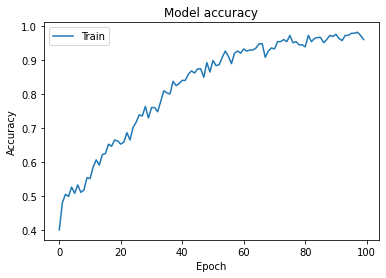

In [ ]:

# Plot training accuracy
plt.plot(CNN_history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

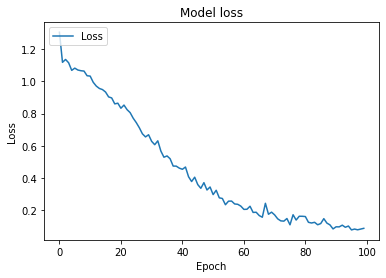

In [ ]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [ ]:
#  cnn model predict 
y_pred_CNN = CNN_model.predict(feature_test)


In [ ]:
# convert result to same form of dummy_test_y
pred_y_CNN = y_pred_CNN.copy()
for i in range(len(y_pred_CNN)):
    j = np.where(y_pred_CNN[i] == np.amax(y_pred_CNN[i]))
    pred_y_CNN[i] = [0, 0, 0, 0]
    pred_y_CNN[i][j] = 1
  
# print acc and report
print(accuracy_score(dummy_test_y,pred_y_CNN))


print(classification_report(dummy_test_y,pred_y_CNN))

0.6857142857142857
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        27
           1       0.74      0.72      0.73        75
           2       0.56      0.59      0.58        37
           3       0.00      0.00      0.00         1

   micro avg       0.69      0.69      0.69       140
   macro avg       0.50      0.51      0.51       140
weighted avg       0.68      0.69      0.68       140
 samples avg       0.69      0.69      0.69       140



C:\Users\xizhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**the first column means Balanced Fund (Low Risk)**

**the second column means Equity Long Only (Low Risk)**

**the third column means Fixed Income Long Only (Low Risk)**

**the fourth column means Long Short Funds (High Risk)*

In [ ]:
str_pred_y = pd.Series(np.zeros(len(pred_y_CNN)))
for i in range(len(pred_y_CNN)):
    j = np.where(pred_y_CNN[i] == 1)
    if j == (np.array([0]),):
        str_pred_y[i] = 'Balanced Fund (Low Risk)'
    elif j == (np.array([1]),):
        str_pred_y[i] = 'Equity Long Only (Low Risk)'
    elif j == (np.array([2]),):
        str_pred_y[i] = 'Fixed Income Long Only (Low Risk)'
    elif j == (np.array([3]),):
        str_pred_y[i] = 'Long Short Funds (High Risk)'

x=str_pred_y


Rnn model

In [ ]:
# create rnn model
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [ ]:
# training 
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, dummy_train_y, epochs=500, batch_size=32)


Epoch 1/500
11/11 [==============================] - 2s 40ms/step - loss: 0.6281 - accuracy: 0.2862
Epoch 2/500
11/11 [==============================] - 0s 39ms/step - loss: 0.5120 - accuracy: 0.4308
Epoch 3/500
11/11 [==============================] - 0s 40ms/step - loss: 0.4607 - accuracy: 0.5292
Epoch 4/500
11/11 [==============================] - 0s 40ms/step - loss: 0.4536 - accuracy: 0.5292
Epoch 5/500
11/11 [==============================] - 0s 39ms/step - loss: 0.4527 - accuracy: 0.5292
Epoch 6/500
11/11 [==============================] - 0s 40ms/step - loss: 0.4516 - accuracy: 0.5292
Epoch 7/500
11/11 [==============================] - 0s 40ms/step - loss: 0.4518 - accuracy: 0.5292
Epoch 8/500
11/11 [==============================] - 0s 42ms/step - loss: 0.4500 - accuracy: 0.5292
Epoch 9/500
11/11 [==============================] - 0s 39ms/step - loss: 0.4504 - accuracy: 0.5292
Epoch 10/500
11/11 [==============================] - 0s 40ms/step - loss: 0.4485 - accuracy: 0.5292

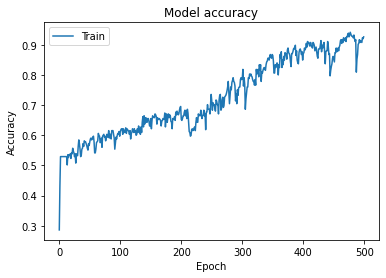

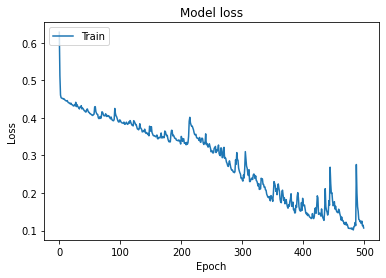

In [ ]:
# Plot training accuracy
plt.plot(RNN_history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(RNN_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [ ]:
# predict the y 
y_pred_RNN = RNN_model.predict(feature_test)
pred_y_RNN = y_pred_RNN.copy()
for i in range(len(y_pred_RNN)):
    j = np.where(y_pred_RNN[i] == np.amax(y_pred_RNN[i]))
    pred_y_RNN[i] = [0, 0, 0, 0]
    pred_y_RNN[i][j] = 1
  
# print acc and report
print(accuracy_score(dummy_test_y,pred_y_RNN))

print(classification_report(dummy_test_y,pred_y_RNN))

0.6785714285714286
              precision    recall  f1-score   support

           0       0.77      0.63      0.69        27
           1       0.76      0.71      0.73        75
           2       0.51      0.65      0.57        37
           3       1.00      1.00      1.00         1

   micro avg       0.68      0.68      0.68       140
   macro avg       0.76      0.75      0.75       140
weighted avg       0.70      0.68      0.68       140
 samples avg       0.68      0.68      0.68       140



Second Cnn model with different setting 

In [ ]:
# Second Cnn model with different setting 
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 200 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(train_X)
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)
# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)   
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
feature_train[22] =feature_train[22]*0.1
feature_train[314] =feature_train[314]*0.1
feature_train[321]=feature_train[321]*0.1
feature_test[85] =feature_test[85]*0.1
def create_CNN_model2():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 4, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN
    
CNN_model = create_CNN_model2()
CNN_history = CNN_model.fit(feature_train, dummy_train_y, epochs=40, batch_size=16)
y_pred_CNN = CNN_model.predict(feature_test)
from sklearn.metrics import accuracy_score
pred_y_CNN = y_pred_CNN.copy()
for i in range(len(y_pred_CNN)):
    j = np.where(y_pred_CNN[i] == np.amax(y_pred_CNN[i]))
    pred_y_CNN[i] = [0, 0, 0, 0]
    pred_y_CNN[i][j] = 1
  




Epoch 1/40
21/21 [==============================] - 0s 4ms/step - loss: 1.1698 - accuracy: 0.4923
Epoch 2/40
21/21 [==============================] - 0s 4ms/step - loss: 1.0646 - accuracy: 0.5323
Epoch 3/40
21/21 [==============================] - 0s 4ms/step - loss: 1.0344 - accuracy: 0.5415
Epoch 4/40
21/21 [==============================] - 0s 4ms/step - loss: 1.0133 - accuracy: 0.5477
Epoch 5/40
21/21 [==============================] - 0s 4ms/step - loss: 0.9999 - accuracy: 0.5846
Epoch 6/40
21/21 [==============================] - 0s 4ms/step - loss: 0.9001 - accuracy: 0.6246
Epoch 7/40
21/21 [==============================] - 0s 4ms/step - loss: 0.9345 - accuracy: 0.6185
Epoch 8/40
21/21 [==============================] - 0s 4ms/step - loss: 0.9080 - accuracy: 0.6185
Epoch 9/40
21/21 [==============================] - 0s 4ms/step - loss: 0.8391 - accuracy: 0.6769
Epoch 10/40
21/21 [==============================] - 0s 4ms/step - loss: 0.8204 - accuracy: 0.6769
Epoch 11/40
21/21 [

In [ ]:
print(accuracy_score(dummy_test_y,pred_y_CNN))

from sklearn.metrics import classification_report
print(classification_report(dummy_test_y,pred_y_CNN))

0.6357142857142857
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        27
           1       0.75      0.59      0.66        75
           2       0.44      0.70      0.54        37
           3       1.00      1.00      1.00         1

   micro avg       0.64      0.64      0.64       140
   macro avg       0.76      0.74      0.74       140
weighted avg       0.69      0.64      0.65       140
 samples avg       0.64      0.64      0.64       140

